# Quantum GANs
Implementation with Qiskit and PyTorch

In [1]:
import copy
import numpy as np
import scipy.sparse as sps
np.set_printoptions(precision=2)

import torch
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim

import qiskit
from qiskit.visualization import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize':(15, 5)})

Base class for all quantum circuits

In [2]:
class _Base:
    def __init__(self, all_qubits, n_qubits, n_layers, layer_format):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.circuit = qiskit.QuantumCircuit(all_qubits, 1)
        self.params = {}
        
        self.layer_format = layer_format
        for layer in range(n_layers):
            self._create_layer(layer)
        
        self._init_param_values()
        
    def _generate_pairs(self, n_qubits):
        pairs = [(i, i + 1) for i in range(n_qubits - 1)]
        pairs.append((n_qubits - 1, 0))
        return pairs
    
    def _init_param_values(self):
        self.params_vals = np.array([])
        for key in self.params.keys():
            random = np.random.random() * 2 * np.pi
            self.params_vals = np.append(self.params_vals, random)
        
    def _create_layer(self, layer):
        # Insert RZ, RX, RZ rotation on each qubit
        for qubit in range(self.n_qubits):
            key = self.layer_format.format(layer, qubit)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.ry(self.params[key], qubit)
        
        # Entangle qubits
        if layer != self.n_layers - 1:
            for qubit_1, qubit_2 in self._generate_pairs(self.n_qubits):
                self.circuit.cz(qubit_1, qubit_2)
            self.circuit.barrier()
        
    def _bind_parameters(self, values):
        parameter_binds = {}
        for key, value in zip(list(self.params.keys()), values):
            parameter_binds[self.params[key]] = value
        return parameter_binds

    
    def __call__(self, params=None):
        if params is None:
            params = self.params_vals
        job = qiskit.execute(self.circuit, self.backend, shots=self.iterations,
                             parameter_binds=[self._bind_parameters(params)])

        result = job.result().get_counts(self.circuit)

        counts = np.array(list(result.values()))
        states = [int(key.split(' ')[0], 2) for key in np.array(list(result.keys()))]

        probabilities = np.zeros(2 ** len(self.circuit.qubits)) 
        probabilities[states] = counts
        probabilities /= self.iterations

        return np.array(probabilities)

Circuits for real and data generation, discrimination and GAN that puts them all together

In [3]:
class RealCircuit(_Base):
    def __init__(self, backend, iterations, n_qubits):
        super().__init__(n_qubits, n_qubits - 1, 1, "r{}{}")
        
        self.backend = backend
        self.iterations = iterations
        
        for qubit in range(self.n_qubits):
            key = self.layer_format.format(1, qubit)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rz(self.params[key], qubit)
        
        self.circuit.barrier()
        
        self._init_param_values()

class GeneratorCircuit(_Base):
    def __init__(self, backend, iterations, n_qubits, n_layers):
        super().__init__(n_qubits, n_qubits - 1, n_layers, "g{}{}")
        
        self.backend = backend
        self.iterations = iterations
        self.circuit.barrier()

class DisciminatorCircuit(_Base):
    def __init__(self, backend, iterations, n_qubits, n_layers):
        super().__init__(n_qubits, n_qubits, n_layers, "d{}{}")
        
        self.backend = backend
        self.iterations = iterations
        self.circuit.measure(n_qubits - 1, 0)

class GANCircuit(_Base):
    def __init__(self, generator, discriminator, backend, iterations):
        super().__init__(discriminator.n_qubits, 0, 0, None)
        
        self.backend = backend
        self.iterations = iterations
        
        self.generator = generator
        self.discriminator = discriminator
        
        self.circuit = generator.circuit.combine(discriminator.circuit)
        
        self.params = {
            "source": generator.params,
            "discriminator": discriminator.params
        }
        self.params_vals = {
            "source": generator.params_vals,
            "discriminator": discriminator.params_vals
        }
    def get_params(self, mode):
        if mode == "source":
            return self.source_params
        return self.discriminator_params
    
    @property
    def source_params(self):
        return self.params["source"], self.params_vals["source"]
    
    @property
    def discriminator_params(self):
        return self.params["discriminator"], self.params_vals["discriminator"]
    
    def _bind_parameters(self, mode, values):
        params_binds = {}
        
        params, params_vals = self.source_params
        if mode == "source":
            params_vals = values
        for key, value in zip(list(params.keys()), params_vals):
            params_binds[params[key]] = value

        params, params_vals = self.discriminator_params
        if mode == "discriminator":
            params_vals = values   
        for key, value in zip(list(params.keys()), params_vals):
            params_binds[params[key]] = value
        
        return params_binds
    
    def __call__(self, mode=None, vals=None):
        job = qiskit.execute(self.circuit, self.backend, shots=self.iterations,
                             parameter_binds=[self._bind_parameters(mode, vals)])

        result = job.result().get_counts(self.circuit)
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probabilities = counts / self.iterations
        expectation = np.sum(states * probabilities)

        return np.array([expectation])

#### Parameters

In [4]:
n_qubits = 5
n_layers = 6

backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1240

#### Real data generator

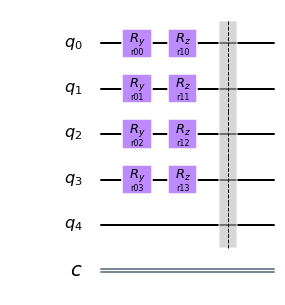

In [5]:
real_data = RealCircuit(backend, shots, n_qubits)
real_data.params_vals = np.array([np.pi * 8 / 5, np.pi * 8 / 5, np.pi / 5, 0, 
                                  np.pi * 7 / 5, np.pi / 2, np.pi, np.pi * 6 / 5])
real_data.circuit.draw()

#### Fake data generator

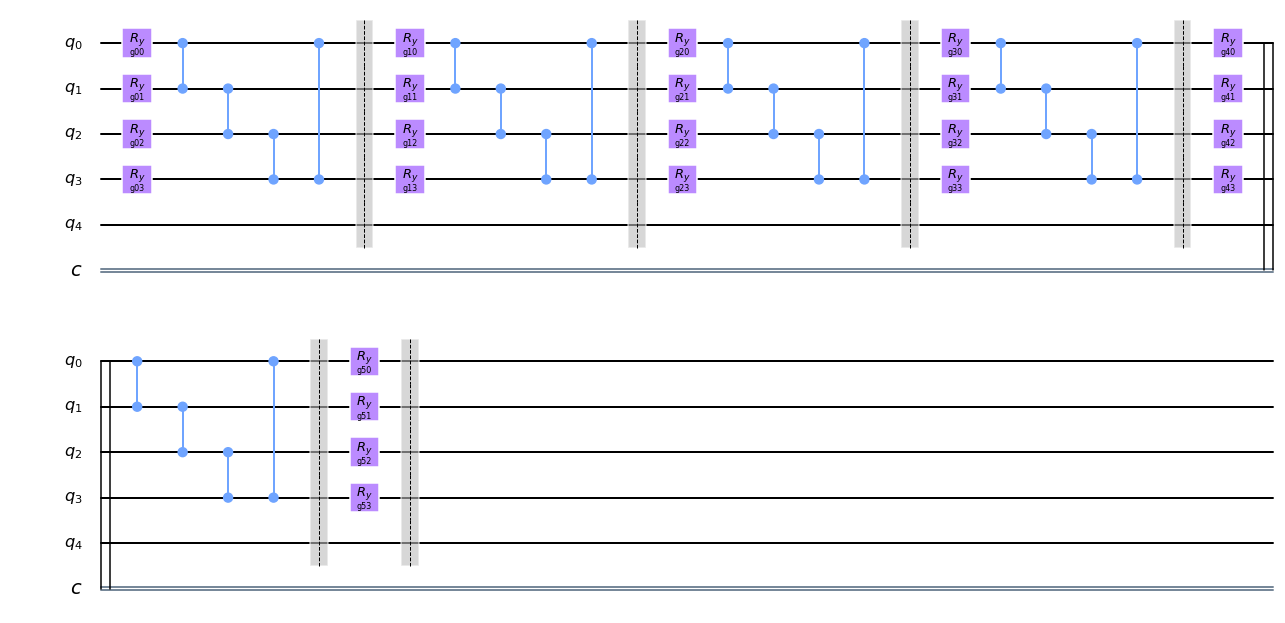

In [6]:
generated_data = GeneratorCircuit(backend, shots, n_qubits, n_layers)
generated_data.circuit.draw()

#### Discriminator

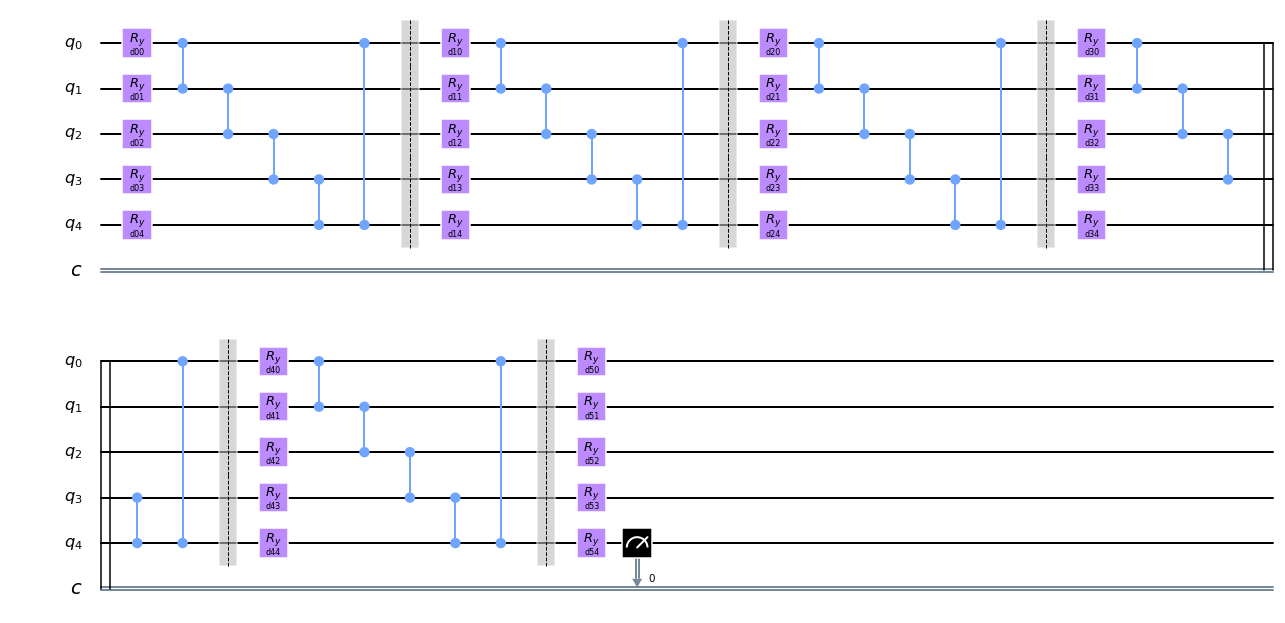

In [7]:
discriminator = DisciminatorCircuit(backend, shots, n_qubits, n_layers)
discriminator.circuit.draw()

### Full GAN circuit

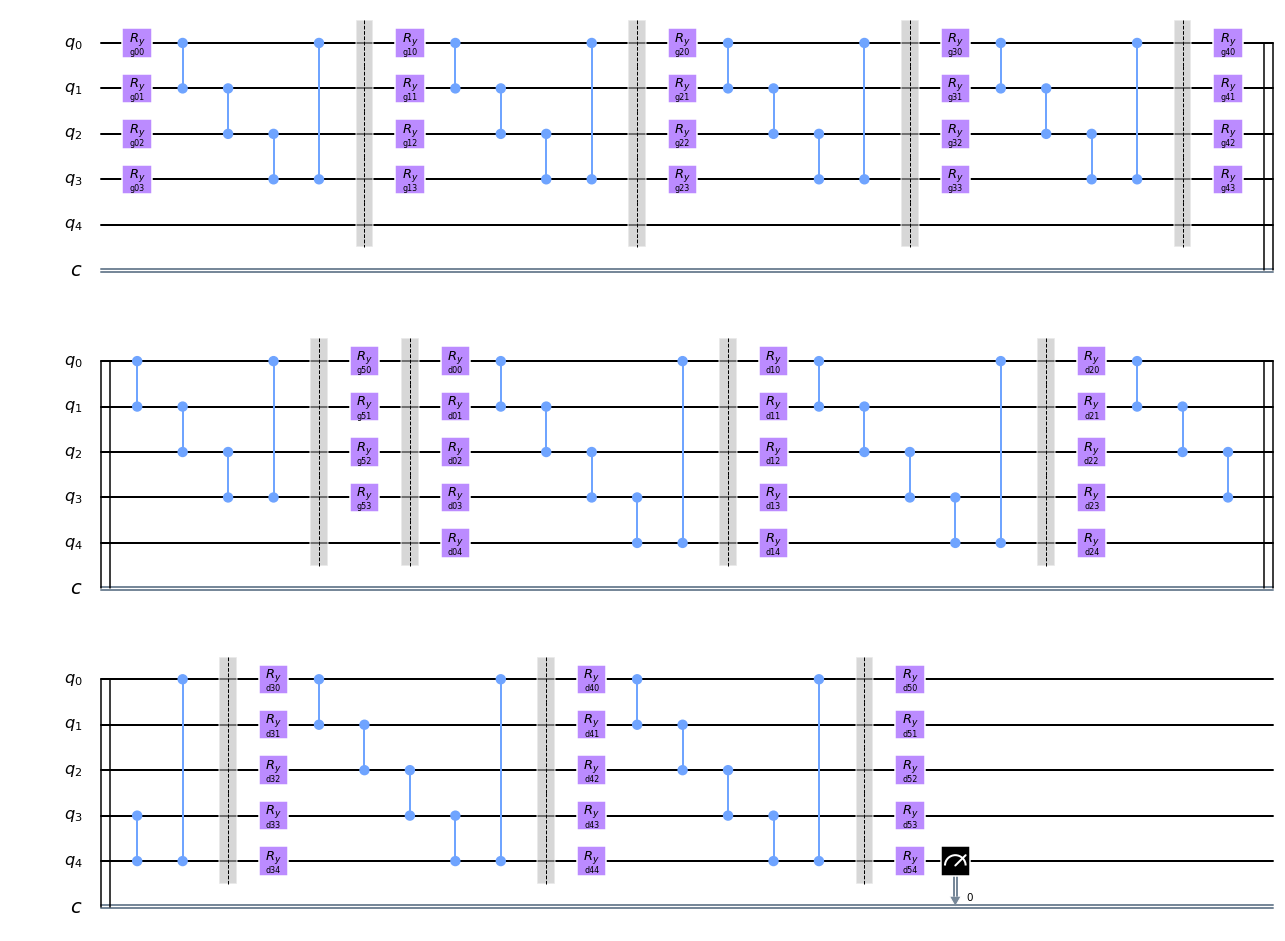

In [12]:
discriminator_gen = GANCircuit(generated_data, discriminator, backend, shots)
discriminator_real = GANCircuit(real_data, discriminator, backend, shots)

discriminator_gen.circuit.draw()

### Defining custom PyTorch layers

In [9]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, mode, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        probabilities = ctx.quantum_circuit(mode, input.data.numpy())
        result = torch.tensor([probabilities])
        ctx.save_for_backward(input, mode, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        input, mode, probabilities = ctx.saved_tensors
        params = np.array(input.tolist())

        shift_right = params + np.eye(len(params)) * ctx.shift / 2
        shift_left = params - np.eye(len(params)) * ctx.shift / 2

        gradients = []
        mode = ["discriminator", "generator"][mode.item()]
        for i in range(len(params)):
            probs_right = ctx.quantum_circuit(mode, shift_right[i])
            probs_left  = ctx.quantum_circuit(mode, shift_left[i])
            
            gradient = probs_right - probs_left
            gradients.append(gradient)
        gradients = torch.tensor(gradients)
        chain_gradients = gradients.float() @ grad_output.float().T
        chain_gradients = torch.flatten(chain_gradients)
        return chain_gradients, None, None, None

class Generator(nn.Module):
    def __init__(self, quantum_circuit, shift):
        super(Generator, self).__init__()
        
        self.mode = torch.tensor(1)
        
        self.quantum_circuit = quantum_circuit
        self.shift = shift
        
        _, params_vals = self.quantum_circuit.source_params
        self.params = torch.nn.Parameter(torch.tensor(params_vals))
        
    def forward(self):
        self.quantum_circuit.params_vals["source"] = self.params.data.numpy()
        return HybridFunction.apply(self.params, self.mode, self.quantum_circuit, self.shift)

class Discriminator(nn.Module):
    def __init__(self, quantum_circuit, shift):
        super(Discriminator, self).__init__()
        
        self.mode = torch.tensor(0)
        
        self.quantum_circuit = quantum_circuit
        self.shift = shift
        
        _, params_vals = self.quantum_circuit.discriminator_params
        self.params = torch.nn.Parameter(torch.tensor(params_vals))
        
    def forward(self):
        self.quantum_circuit.params_vals["discriminator"] = self.params.data.numpy()
        return HybridFunction.apply(self.params, self.mode, self.quantum_circuit, self.shift)

#### Training

In [13]:
model_gen = Generator(discriminator_gen, np.pi / 6)
model_dis_g = Discriminator(discriminator_gen, np.pi / 6)
model_dis_r = Discriminator(discriminator_real, np.pi / 6)

# Sharing parameters between discriminatiors
model_dis_r.params = model_dis_g.params

loss = nn.BCELoss()

real_label = 1
fake_label = 0

optimizer_gen = optim.Adam(model_gen.parameters(), lr=0.01)
optimizer_dis = optim.Adam(model_dis_r.parameters(), lr=0.01)

epochs = 1000
losses_gen = []
losses_dis_r = []
losses_dis_g = []

model_gen.train()
model_dis_g.train()
model_dis_r.train()

Discriminator()

In [14]:
for epoch in range(epochs):
    # ---------------------------
    # Train discriminator on real data
    model_dis_r.zero_grad()
    output = model_dis_r()
    
    label = torch.tensor([[real_label]]).double()
    loss_dis_r = loss(output, label)
    loss_dis_r.backward()
    losses_dis_r.append(loss_dis_r)
    
    # Train discriminator on generated data
    output = model_dis_g()
    
    label = torch.tensor([[fake_label]]).double()
    loss_dis_g = loss(output, label)
    loss_dis_g.backward()
    losses_dis_g.append(loss_dis_g)
    
    loss_dis = loss_dis_r + loss_dis_g
    
    optimizer_dis.step()
    model_gen.quantum_circuit.params_vals["discriminator"] = model_dis_r.params.data.numpy()
    # ---------------------------
    # Train generator
    model_gen.zero_grad()
    output = model_gen()
    
    label = torch.tensor([[real_label]]).double()
    loss_gen = loss(output, label)
    loss_gen.backward()
    losses_gen.append(loss_gen.item())
    
    optimizer_gen.step()
    model_dis_r.quantum_circuit.params_vals["source"] = model_gen.params.data.numpy()
    # ---------------------------
    
    if epoch % 50 == 0:
        print('Training [{:3.0f}%] Loss_G: {:7.4f} Loss_D: {:7.4f}'.format(
            100. * epoch / epochs, losses_gen[-1], losses_dis_r[-1] + losses_dis_g[-1]))

Training [  0%] Loss_G:  0.7326 Loss_D:  1.4865
Training [  5%] Loss_G:  1.5282 Loss_D:  0.3229
Training [ 10%] Loss_G:  1.9930 Loss_D:  0.2375
Training [ 15%] Loss_G:  2.5690 Loss_D:  0.1594
Training [ 20%] Loss_G:  2.8324 Loss_D:  0.1631
Training [ 25%] Loss_G:  2.8324 Loss_D:  0.1509
Training [ 30%] Loss_G:  2.7534 Loss_D:  0.1633
Training [ 35%] Loss_G:  3.0624 Loss_D:  0.1500
Training [ 40%] Loss_G:  3.0624 Loss_D:  0.1467
Training [ 45%] Loss_G:  3.0120 Loss_D:  0.1679
Training [ 50%] Loss_G:  2.4689 Loss_D:  0.1863
Training [ 55%] Loss_G:  2.8054 Loss_D:  0.1669
Training [ 60%] Loss_G:  3.0624 Loss_D:  0.1484
Training [ 65%] Loss_G:  3.6889 Loss_D:  0.0851
Training [ 70%] Loss_G:  3.7556 Loss_D:  0.0998
Training [ 75%] Loss_G:  3.7907 Loss_D:  0.0658
Training [ 80%] Loss_G:  4.1784 Loss_D:  0.0540
Training [ 85%] Loss_G:  3.5675 Loss_D:  0.0724
Training [ 90%] Loss_G:  3.2517 Loss_D:  0.0841
Training [ 95%] Loss_G:  3.0798 Loss_D:  0.1026


Text(0.5, 1.0, 'Discriminator loss')

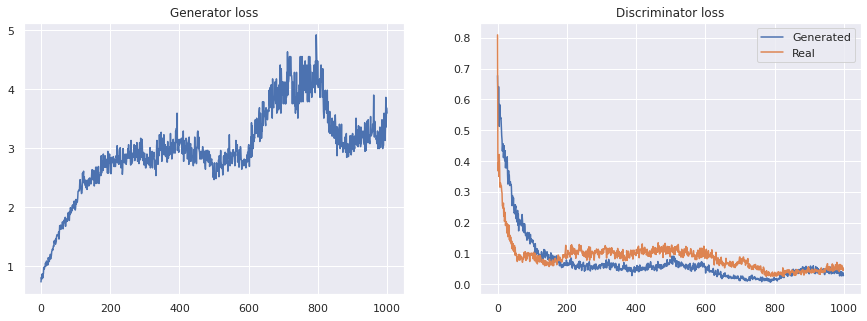

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)

axes[0].plot(losses_gen) 
axes[0].set_title("Generator loss")
axes[1].plot(losses_dis_g, label="Generated")
axes[1].plot(losses_dis_r, label="Real")
axes[1].legend()
axes[1].set_title("Discriminator loss")

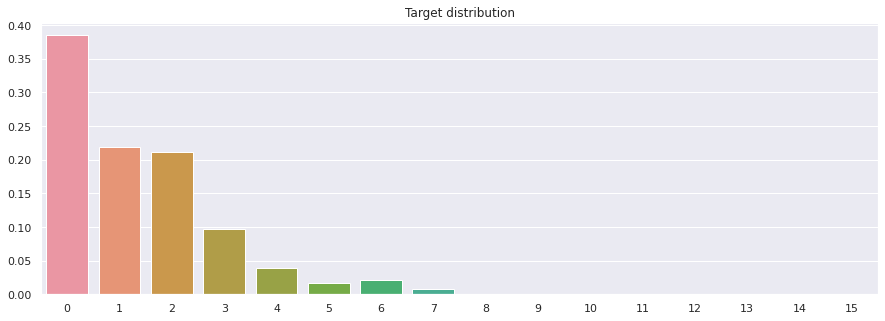

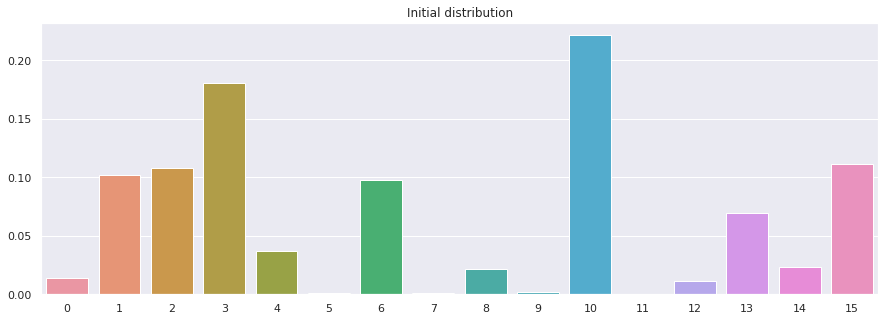

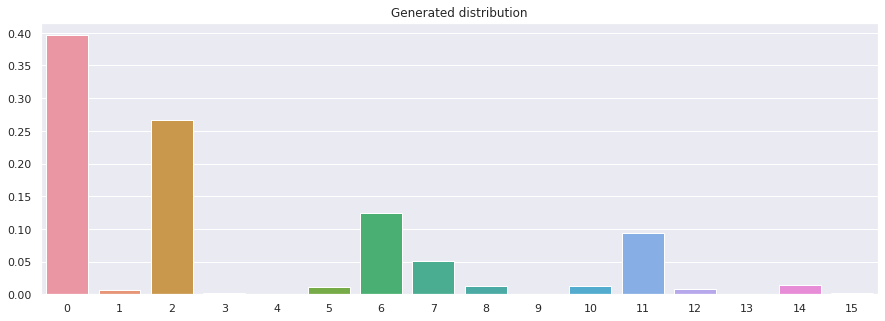

In [16]:
real_distribution = copy.deepcopy(real_data)
real_distribution.circuit.measure_all()

fake_distribution = copy.deepcopy(generated_data)
fake_distribution.circuit.measure_all()

distribution_1 = real_distribution()
distribution_1 = distribution_1[:int(len(distribution_1) / 2)]
distribution_2 = fake_distribution()
distribution_2 = distribution_2[:int(len(distribution_2) / 2)]
distribution_3 = fake_distribution(model_gen.params.data.numpy())
distribution_3 = distribution_3[:int(len(distribution_3) / 2)]

sns.barplot(x = np.arange(len(distribution_1)), y = distribution_1)
plt.title("Target distribution")
plt.show()
sns.barplot(x = np.arange(len(distribution_2)), y = distribution_2)
plt.title("Initial distribution")
plt.show()
sns.barplot(x = np.arange(len(distribution_3)), y = distribution_3)
plt.title("Generated distribution")
plt.show()